# Introduction

This notebook is meant for testing various neural network architectures that take in (combinations of) WYS node embeddings and heuritics for the musae-GitHub network. The strategies tried are:


*   Input: Hadamard product of both nodes' WYS (dim = 64), Model: Single-input model with increasing then decreasing layer sizes
* Input: Heuristic (dim = 56), Model: Single-input model with increasing then decreasing layer sizes  
* Input: Heuristic + WYS (Hadamard) concatenation (dim = 120), Model: Single-input model with increasing then decreasing layer sizes
* Input: WYS (Concatenated, dim = 128), Model: Single-input model with increasing then decreasing layer sizes
* Input: Heuristic + WYS (concatenated) concatenation (dim = 184), Model: Single-input model with increasing then decreasing layer sizes
* Input: WYS embedding of each node separately (dim = 64 + 64), Model: Double input model with hadamard product product of semi-final layers followed by sigmoud activation.

The loss to be used is binary-crossentropy.



In [12]:
!pip install stellargraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
# Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd # Pandas to create small dataframes 
import numpy as np
import datetime # Convert to unix time
import time # Convert to unix time
# If numpy is not installed already : pip3 install numpy
import numpy as np # Do aritmetic operations on arrays
# Matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns # Plots
from matplotlib import rcParams # Size of plots  
import math
import pickle
import os
# To install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
from tqdm.notebook import tqdm
import random
from sklearn.model_selection import train_test_split
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint as sp_randint
from xgboost import XGBClassifier
from stellargraph.core import StellarGraph
from pandas import read_hdf

# Data preperation

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_path = "gdrive/My Drive/GitHub Link Prediction/"

In [ ]:
df_train = pd.read_csv(data_path+"gh_pos_train_91.csv", index_col = 0)

In [ ]:
df_train.head()

,src,dest,link
91155,6639,22064,1
32456,2040,26233,1
245270,23636,36468,1
127747,9723,17816,1
70892,5068,16240,1


In [ ]:
emb_file = open(data_path+"gh_wys_embeddings_91.pkl", "rb")
embeddings = pickle.load(emb_file)
emb_file.close()
embeddings.shape

(37700, 64)

In [ ]:
train_graph = nx.from_pandas_edgelist(df_train, source='src', target='dest', create_using=nx.MultiDiGraph())

In [ ]:
G = StellarGraph.from_networkx(train_graph)

In [ ]:
nodes = list(G.nodes())
nodes[:5]

[6639, 22064, 2040, 26233, 23636]

In [ ]:
emb_dict = {}
for i, node in enumerate(nodes):
  emb_dict[node] = np.array(embeddings[i].reshape(1,64))

In [ ]:
combined_tr = pd.read_csv(data_path+"gh_train_91.csv", index_col = 0)
print(combined_tr.shape)
combined_tr.head()

(516678, 3)


,src,dest,link
132913,10080,28269,1
97601,7104,31695,1
127442,21330,20345,0
189136,13326,30293,0
61075,13218,37521,0


In [ ]:
combined_test = pd.read_csv(data_path+"gh_test_91.csv", index_col = 0)
combined_test.head()

,src,dest,link
222440,28906,32893,0
48306,35757,23700,0
265591,26731,28777,1
132547,5482,11624,0
124965,24379,459,0


In [ ]:
train_y = combined_tr['link']
test_y = combined_test['link'] 
print(train_y.shape, test_y.shape)

(516678,) (62325,)


In [ ]:
train_y = np.expand_dims(train_y, axis = 1)
test_y = np.expand_dims(test_y, axis = 1)
print(train_y.shape, test_y.shape)

(516678, 1) (62325, 1)


In [ ]:
# get training embeddings
train_hadamard = []
train_concat = []
train_src = []
train_dest = []
for i, row in tqdm(combined_tr.iterrows()):
  hadamard = (emb_dict[row['src']][0]) * (emb_dict[row['dest']][0])
  concat = np.concatenate((emb_dict[row['src']][0], emb_dict[row['dest']][0]))
  train_hadamard.append(hadamard)
  train_concat.append(concat)
  train_src.append(emb_dict[row['src']][0])
  train_dest.append(emb_dict[row['dest']][0])
train_hadamard = np.array(train_hadamard)
train_concat = np.array(train_concat)
train_src = np.array(train_src)
train_dest = np.array(train_dest)
print(train_hadamard.shape)
print(train_concat.shape)
print(train_src.shape)
print(train_dest.shape)

0it [00:00, ?it/s]

(516678, 64)
(516678, 128)
(516678, 64)
(516678, 64)


In [ ]:
# get testing embeddings
test_hadamard = []
test_concat = []
test_src = []
test_dest = []
for i, row in tqdm(combined_test.iterrows()):
  hadamard = (emb_dict[row['src']][0]) * (emb_dict[row['dest']][0])
  concat = np.concatenate((emb_dict[row['src']][0], emb_dict[row['dest']][0]))
  test_hadamard.append(hadamard)
  test_concat.append(concat)
  test_src.append(emb_dict[row['src']][0])
  test_dest.append(emb_dict[row['dest']][0])
test_hadamard = np.array(test_hadamard)
test_concat = np.array(test_concat)
test_src = np.array(test_src)
test_dest = np.array(test_dest)
print(test_hadamard.shape)
print(test_concat.shape)
print(test_src.shape)
print(test_dest.shape)

0it [00:00, ?it/s]

(62325, 64)
(62325, 128)
(62325, 64)
(62325, 64)


In [ ]:
#reading
train_heuristic = read_hdf(data_path + 'gh_fea_sample/gh_storage_sample_stage4.h5', 'train_df',mode='r')
test_heuristic = read_hdf(data_path + 'gh_fea_sample/gh_storage_sample_stage4.h5', 'test_df',mode='r')

In [ ]:
train_heuristic.drop(['src', 'dest','link'],axis=1,inplace=True)
test_heuristic.drop(['src', 'dest','link'],axis=1,inplace=True)
print(train_heuristic.shape, test_heuristic.shape)

(516678, 56) (62325, 56)


# Modelling

In [15]:
import tensorflow 
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, concatenate, Input, BatchNormalization, Multiply, Concatenate
from tensorflow.keras import backend as K
from numpy import asarray
from numpy import zeros_like
from time import time
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import tensorflow_addons as tfa

## Experiment 1:
#### Input: Hadamard product of both nodes' WYS (dim = 64), Model: Single-input model with increasing then decreasing layer sizes

In [ ]:
# Creating the model
model_name = "model1"
tensorflow.keras.backend.clear_session()

input = Input(shape=(64,))
x = Dense(128, activation='relu', kernel_initializer='he_normal')(input)
# x = Dropout(0.2)(x)
# x = BatchNormalization()(x)

x = Dense(256, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

x = Dense(128, activation='relu', kernel_initializer='he_normal')(x)
# x = Dropout(0.2)(x)
# x = BatchNormalization()(x)

x = Dense(64, activation='relu', kernel_initializer='he_normal')(x)
# x = Dropout(0.2)(x)
# x = BatchNormalization()(x)

x = Dense(16, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

output = Dense(1, activation='sigmoid', kernel_initializer='glorot_normal')(x)

model1 = Model(inputs=input, outputs=output)
model1.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.0001),metrics='accuracy')
print(model1.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                             

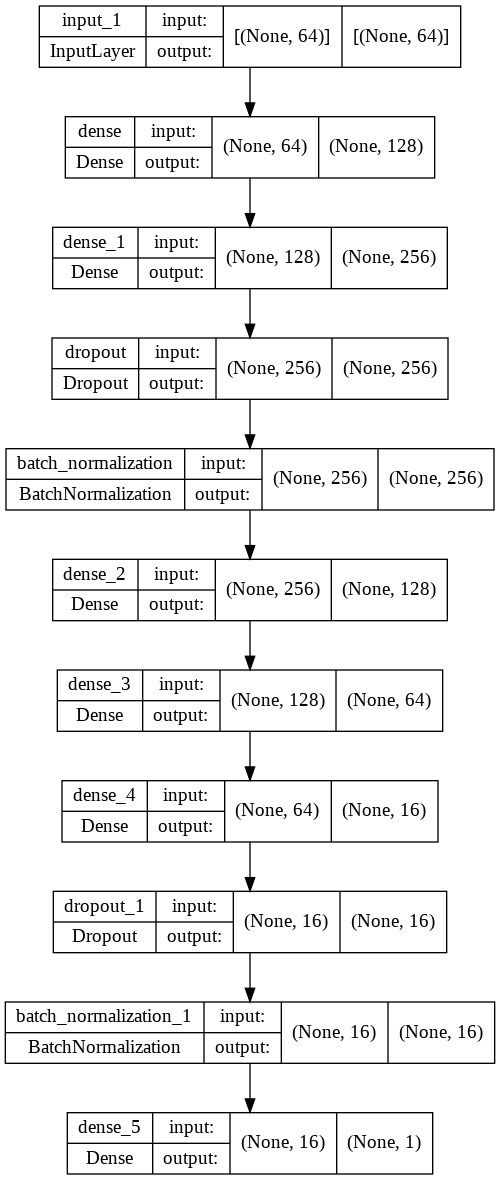

In [ ]:
earlystop = EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1)
modelcheckpt = ModelCheckpoint(filepath=model_name+".h5")
tensorflow.keras.utils.plot_model(model1, to_file=model_name+'.png', show_shapes=True)

In [ ]:
history = model1.fit(train_hadamard, train_y, epochs=50, verbose=1, batch_size=128, validation_data=(test_hadamard, test_y), callbacks=[earlystop, modelcheckpt])

Epoch 1/50
4037/4037 [==============================] - 24s 5ms/step - loss: 0.5366 - accuracy: 0.7314 - val_loss: 0.4990 - val_accuracy: 0.7473
Epoch 2/50
4037/4037 [==============================] - 31s 8ms/step - loss: 0.4944 - accuracy: 0.7601 - val_loss: 0.4816 - val_accuracy: 0.7636
Epoch 3/50
4037/4037 [==============================] - 27s 7ms/step - loss: 0.4790 - accuracy: 0.7724 - val_loss: 0.4703 - val_accuracy: 0.7730
Epoch 4/50
4037/4037 [==============================] - 20s 5ms/step - loss: 0.4687 - accuracy: 0.7787 - val_loss: 0.4600 - val_accuracy: 0.7786
Epoch 5/50
4037/4037 [==============================] - 20s 5ms/step - loss: 0.4601 - accuracy: 0.7836 - val_loss: 0.4526 - val_accuracy: 0.7823
Epoch 6/50
4037/4037 [==============================] - 21s 5ms/step - loss: 0.4525 - accuracy: 0.7880 - val_loss: 0.4618 - val_accuracy: 0.7802
Epoch 7/50
4037/4037 [==============================] - 20s 5ms/step - loss: 0.4455 - accuracy: 0.7917 - val_loss: 0.4720 - val_ac

In [ ]:
# model1 = tensorflow.keras.models.load_model(model_name+".h5")
test_pred = model1.predict(test_hadamard)
test_pred = [1 if x >= 0.5 else 0 for x in test_pred]
hh_f1 = f1_score(test_y, test_pred)
print(hh_f1)

0.8189114898295767


## Experiment 2: 
#### Input: Heuristic (dim = 56), Model: Single-input model with increasing then decreasing layer sizes

In [ ]:
# Creating the model
model_name = "model2"
tensorflow.keras.backend.clear_session()

input = Input(shape=(56,))
x = Dense(256, activation='relu', kernel_initializer='he_normal')(input)
# x = Dropout(0.2)(x)
# x = BatchNormalization()(x)

x = Dense(256, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

x = Dense(128, activation='relu', kernel_initializer='he_normal')(x)
# x = Dropout(0.2)(x)
# x = BatchNormalization()(x)

x = Dense(64, activation='relu', kernel_initializer='he_normal')(x)
# x = Dropout(0.2)(x)
# x = BatchNormalization()(x)

x = Dense(16, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

output = Dense(1, activation='sigmoid', kernel_initializer='glorot_normal')(x)

model2 = Model(inputs=input, outputs=output)
model2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.0001),metrics='accuracy')
print(model2.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 56)]              0         
                                                                 
 dense (Dense)               (None, 256)               14592     
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                             

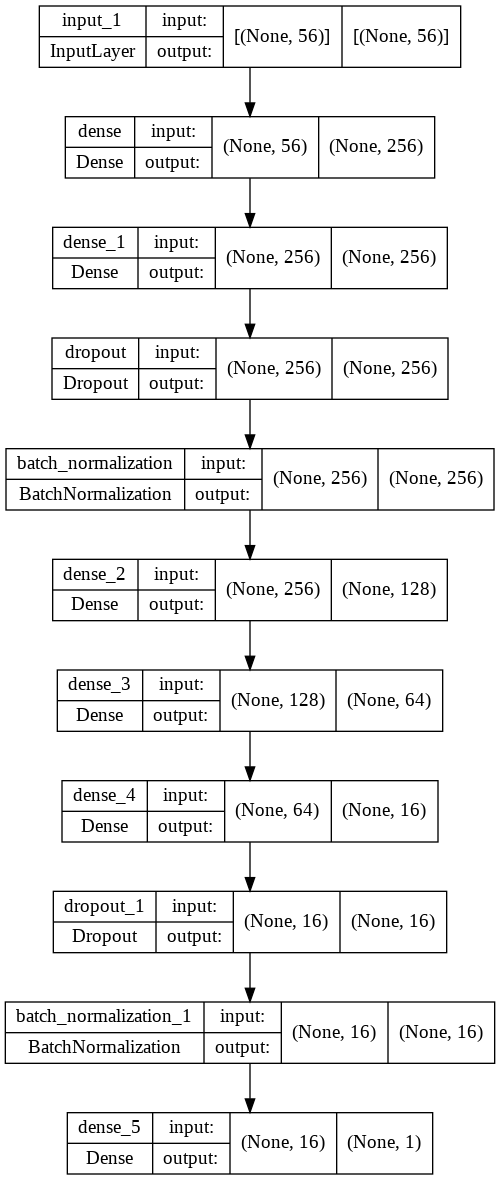

In [ ]:
earlystop = EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1)
modelcheckpt = ModelCheckpoint(filepath=model_name+".h5")
tensorflow.keras.utils.plot_model(model2, to_file=model_name+'.png', show_shapes=True)

In [ ]:
history = model2.fit(train_heuristic, train_y, epochs=50, verbose=1, batch_size=128, validation_data=(test_heuristic, test_y), callbacks=[earlystop, modelcheckpt])

Epoch 1/50
4037/4037 [==============================] - 21s 5ms/step - loss: 0.2667 - accuracy: 0.8900 - val_loss: 0.3216 - val_accuracy: 0.8720
Epoch 2/50
4037/4037 [==============================] - 21s 5ms/step - loss: 0.1877 - accuracy: 0.9297 - val_loss: 0.3125 - val_accuracy: 0.8727
Epoch 3/50
4037/4037 [==============================] - 20s 5ms/step - loss: 0.1708 - accuracy: 0.9351 - val_loss: 0.3195 - val_accuracy: 0.8692
Epoch 4/50
4037/4037 [==============================] - 21s 5ms/step - loss: 0.1696 - accuracy: 0.9355 - val_loss: 0.3244 - val_accuracy: 0.8759
Epoch 5/50
4037/4037 [==============================] - 20s 5ms/step - loss: 0.1553 - accuracy: 0.9412 - val_loss: 0.3173 - val_accuracy: 0.8705
Epoch 6/50
4037/4037 [==============================] - 23s 6ms/step - loss: 0.1519 - accuracy: 0.9415 - val_loss: 0.3119 - val_accuracy: 0.8763
Epoch 7/50
4037/4037 [==============================] - 32s 8ms/step - loss: 0.1483 - accuracy: 0.9430 - val_loss: 0.3116 - val_ac

In [ ]:
model2 = tensorflow.keras.models.load_model(model_name+".h5")
test_pred = model2.predict(test_heuristic)
test_pred = [1 if x >= 0.5 else 0 for x in test_pred]
heuristic_f1 = f1_score(test_y, test_pred)
print(heuristic_f1)

0.8906460708593846


## Experiment 3:
#### Input: Heuristic + WYS (Hadamard) concatenation (dim = 120), Model: Single-input model with increasing then decreasing layer sizes

In [ ]:
train_heuristic_hadamard = np.hstack((train_heuristic, train_hadamard))
print(train_heuristic_hadamard.shape)
test_heuristic_hadamard = np.hstack((test_heuristic, test_hadamard))
print(test_heuristic_hadamard.shape)

(516678, 120)
(62325, 120)


In [ ]:
# Creating the model
model_name = 'model3'
tensorflow.keras.backend.clear_session()

input = Input(shape=(120,))
x = Dense(512, activation='relu', kernel_initializer='he_normal')(input)
# x = Dropout(0.2)(x)
# x = BatchNormalization()(x)

x = Dense(256, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

x = Dense(128, activation='relu', kernel_initializer='he_normal')(x)
# x = Dropout(0.2)(x)
# x = BatchNormalization()(x)

x = Dense(64, activation='relu', kernel_initializer='he_normal')(x)
# x = Dropout(0.2)(x)
# x = BatchNormalization()(x)

x = Dense(16, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

output = Dense(1, activation='sigmoid', kernel_initializer='glorot_normal')(x)

model3 = Model(inputs=input, outputs=output)
model3.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.0001),metrics='accuracy')
print(model3.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120)]             0         
                                                                 
 dense (Dense)               (None, 512)               61952     
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                             

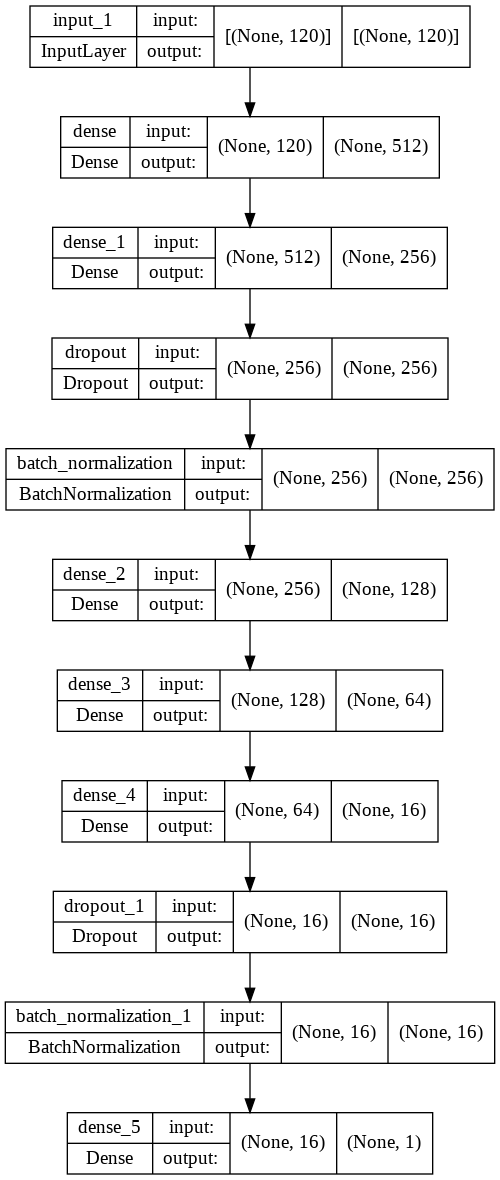

In [ ]:
earlystop = EarlyStopping(monitor = 'val_loss', patience=6, verbose = 1)
modelcheckpt = ModelCheckpoint(filepath=model_name+".h5")
tensorflow.keras.utils.plot_model(model3, to_file=model_name+'.png', show_shapes=True)

In [ ]:
history = model3.fit(train_heuristic_hadamard, train_y, epochs=50, verbose=1, batch_size=128, validation_data=(test_heuristic_hadamard, test_y), callbacks=[earlystop, modelcheckpt])

Epoch 1/50
4037/4037 [==============================] - 26s 6ms/step - loss: 0.2284 - accuracy: 0.9107 - val_loss: 0.4434 - val_accuracy: 0.8652
Epoch 2/50
4037/4037 [==============================] - 21s 5ms/step - loss: 0.1693 - accuracy: 0.9357 - val_loss: 0.3583 - val_accuracy: 0.8673
Epoch 3/50
4037/4037 [==============================] - 20s 5ms/step - loss: 0.1536 - accuracy: 0.9421 - val_loss: 0.3403 - val_accuracy: 0.8617
Epoch 4/50
4037/4037 [==============================] - 21s 5ms/step - loss: 0.1497 - accuracy: 0.9434 - val_loss: 0.3004 - val_accuracy: 0.8786
Epoch 5/50
4037/4037 [==============================] - 24s 6ms/step - loss: 0.1434 - accuracy: 0.9449 - val_loss: 0.3106 - val_accuracy: 0.8748
Epoch 6/50
4037/4037 [==============================] - 22s 6ms/step - loss: 0.1386 - accuracy: 0.9472 - val_loss: 0.3062 - val_accuracy: 0.8828
Epoch 7/50
4037/4037 [==============================] - 21s 5ms/step - loss: 0.1356 - accuracy: 0.9478 - val_loss: 0.2857 - val_ac

In [ ]:
model3 = tensorflow.keras.models.load_model(model_name+".h5")
test_pred = model3.predict(test_heuristic_hadamard)
test_pred = [1 if x >= 0.5 else 0 for x in test_pred]
heuristic_hadamard_f1 = f1_score(test_y, test_pred)
print(heuristic_hadamard_f1)

0.8706023627158249


## Experiment 4
#### Input: WYS embedding of each node separately (dim = 64 + 64), Model: Double input model with hadamard product product of semi-final layers followed by sigmoud activation.

In [ ]:
# Creating the model
model_name = 'model6'
tensorflow.keras.backend.clear_session()

input1 = Input(shape=(64,))
x1 = Dense(128, activation='relu', kernel_initializer='he_normal')(input1)
# x1 = Dropout(0.2)(x1)
# x1 = BatchNormalization()(x1)

x1 = Dense(256, activation='relu', kernel_initializer='he_normal')(x1)
x1 = Dropout(0.2)(x1)
x1 = BatchNormalization()(x1)

x1 = Dense(128, activation='relu', kernel_initializer='he_normal')(x1)
# x1 = Dropout(0.2)(x1)
# x1 = BatchNormalization()(x1)

x1 = Dense(64, activation='relu', kernel_initializer='he_normal')(x1)
x1 = Dropout(0.2)(x1)
x1 = BatchNormalization()(x1)

input2 = Input(shape=(64,))
x2 = Dense(128, activation='relu', kernel_initializer='he_normal')(input2)
# x2 = Dropout(0.2)(x2)
# x2 = BatchNormalization()(x2)

x2 = Dense(256, activation='relu', kernel_initializer='he_normal')(x2)
x2 = Dropout(0.2)(x2)
x2 = BatchNormalization()(x2)

x2 = Dense(128, activation='relu', kernel_initializer='he_normal')(x2)
# x2 = Dropout(0.2)(x2)
# x2 = BatchNormalization()(x2)

x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(x2)
x2 = Dropout(0.2)(x2)
x2 = BatchNormalization()(x2)

x = Multiply()([x1, x2])

x = Dense(16, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

output = Dense(1, activation='sigmoid', kernel_initializer='glorot_normal')(x)

model6 = Model(inputs=[input1, input2], outputs=output)
model6.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.0001),metrics='accuracy')
print(model6.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          8320        ['input_1[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 128)          8320        ['input_2[0][0]']                
                                                                                              

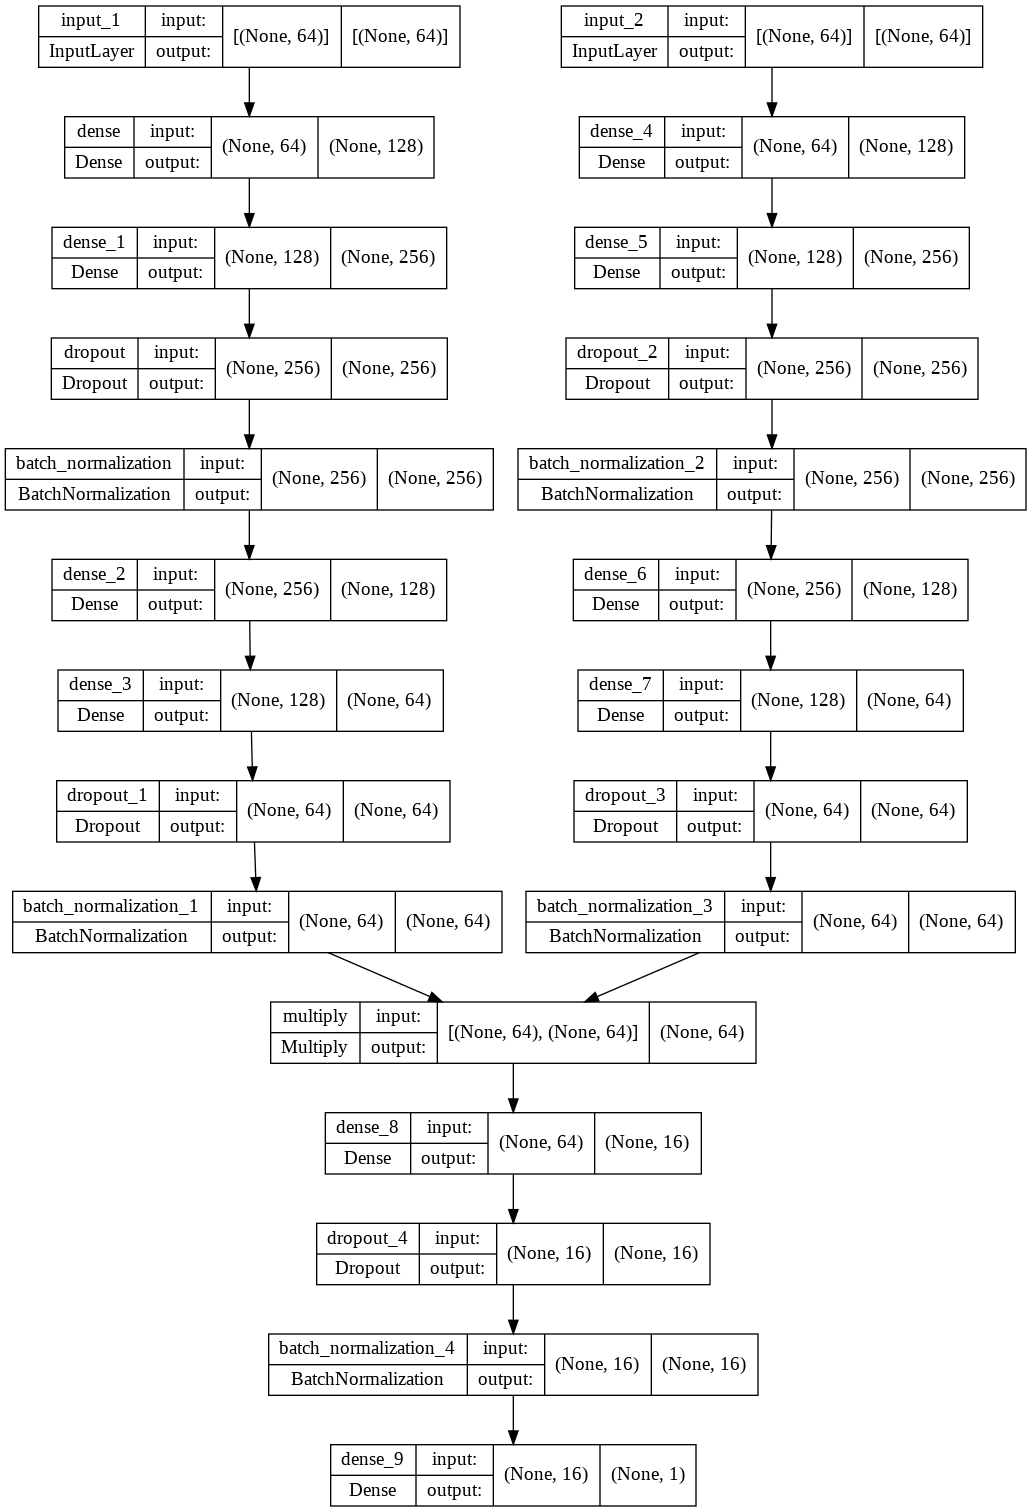

In [ ]:
earlystop = EarlyStopping(monitor = 'val_loss', patience=6, verbose = 1)
modelcheckpt = ModelCheckpoint(filepath=model_name+".h5")
tensorflow.keras.utils.plot_model(model3, to_file=model_name+'.png', show_shapes=True)

In [ ]:
history = model6.fit([train_src, train_dest], train_y, epochs=50, verbose=1, batch_size=128, validation_data=([test_src, test_dest], test_y), callbacks=[earlystop, modelcheckpt])

Epoch 1/50
4037/4037 [==============================] - 32s 7ms/step - loss: 0.5731 - accuracy: 0.6974 - val_loss: 0.4268 - val_accuracy: 0.7981
Epoch 2/50
4037/4037 [==============================] - 30s 8ms/step - loss: 0.3895 - accuracy: 0.8280 - val_loss: 0.3529 - val_accuracy: 0.8418
Epoch 3/50
4037/4037 [==============================] - 31s 8ms/step - loss: 0.3338 - accuracy: 0.8564 - val_loss: 0.3333 - val_accuracy: 0.8552
Epoch 4/50
4037/4037 [==============================] - 30s 7ms/step - loss: 0.3112 - accuracy: 0.8665 - val_loss: 0.3395 - val_accuracy: 0.8529
Epoch 5/50
4037/4037 [==============================] - 31s 8ms/step - loss: 0.2984 - accuracy: 0.8728 - val_loss: 0.3150 - val_accuracy: 0.8669
Epoch 6/50
4037/4037 [==============================] - 31s 8ms/step - loss: 0.2903 - accuracy: 0.8768 - val_loss: 0.3164 - val_accuracy: 0.8671
Epoch 7/50
4037/4037 [==============================] - 30s 7ms/step - loss: 0.2838 - accuracy: 0.8798 - val_loss: 0.3124 - val_ac

In [ ]:
model6 = tensorflow.keras.models.load_model(model_name+".h5")
test_pred = model6.predict([test_src, test_dest])
test_pred = [1 if x >= 0.5 else 0 for x in test_pred]
heuristic_hadamard_f1 = f1_score(test_y, test_pred)
print(heuristic_hadamard_f1)

0.8792054125861163


## Experiment 5
#### Input: WYS embedding of each node and heuristics separately (dim = 64 + 64 + 56), Model: Double input model with hadamard product product of semi-final layers followed by sigmoud activation.

In [ ]:
# Creating the model
model_name = 'model7'
tensorflow.keras.backend.clear_session()

input1 = Input(shape=(64,))
x1 = Dense(128, activation='relu', kernel_initializer='he_normal')(input1)
# x1 = Dropout(0.2)(x1)
# x1 = BatchNormalization()(x1)

x1 = Dense(256, activation='relu', kernel_initializer='he_normal')(x1)
x1 = Dropout(0.2)(x1)
x1 = BatchNormalization()(x1)

x1 = Dense(128, activation='relu', kernel_initializer='he_normal')(x1)
# x1 = Dropout(0.2)(x1)
# x1 = BatchNormalization()(x1)

x1 = Dense(64, activation='relu', kernel_initializer='he_normal')(x1)
x1 = Dropout(0.2)(x1)
x1 = BatchNormalization()(x1)

input2 = Input(shape=(64,))
x2 = Dense(128, activation='relu', kernel_initializer='he_normal')(input2)
# x2 = Dropout(0.2)(x2)
# x2 = BatchNormalization()(x2)

x2 = Dense(256, activation='relu', kernel_initializer='he_normal')(x2)
x2 = Dropout(0.2)(x2)
x2 = BatchNormalization()(x2)

x2 = Dense(128, activation='relu', kernel_initializer='he_normal')(x2)
# x2 = Dropout(0.2)(x2)
# x2 = BatchNormalization()(x2)

x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(x2)
x2 = Dropout(0.2)(x2)
x2 = BatchNormalization()(x2)

input3 = Input(shape=(56,))
x3 = Dense(128, activation='relu', kernel_initializer='he_normal')(input3)
# x1 = Dropout(0.2)(x1)
# x1 = BatchNormalization()(x1)

x3 = Dense(256, activation='relu', kernel_initializer='he_normal')(x3)
x3 = Dropout(0.2)(x3)
x3 = BatchNormalization()(x3)

x3 = Dense(128, activation='relu', kernel_initializer='he_normal')(x3)
# x3 = Dropout(0.2)(x3)
# x3 = BatchNormalization()(x3)

x3 = Dense(64, activation='relu', kernel_initializer='he_normal')(x3)
x3 = Dropout(0.2)(x3)
x3 = BatchNormalization()(x3)

x = Multiply()([x1, x2, x3])

x = Dense(16, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

output = Dense(1, activation='sigmoid', kernel_initializer='glorot_normal')(x)

model7 = Model(inputs=[input1, input2, input3], outputs=output)
model7.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.0001),metrics='accuracy')
print(model7.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 56)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          8320        ['input_1[0][0]']                
                                                                                              

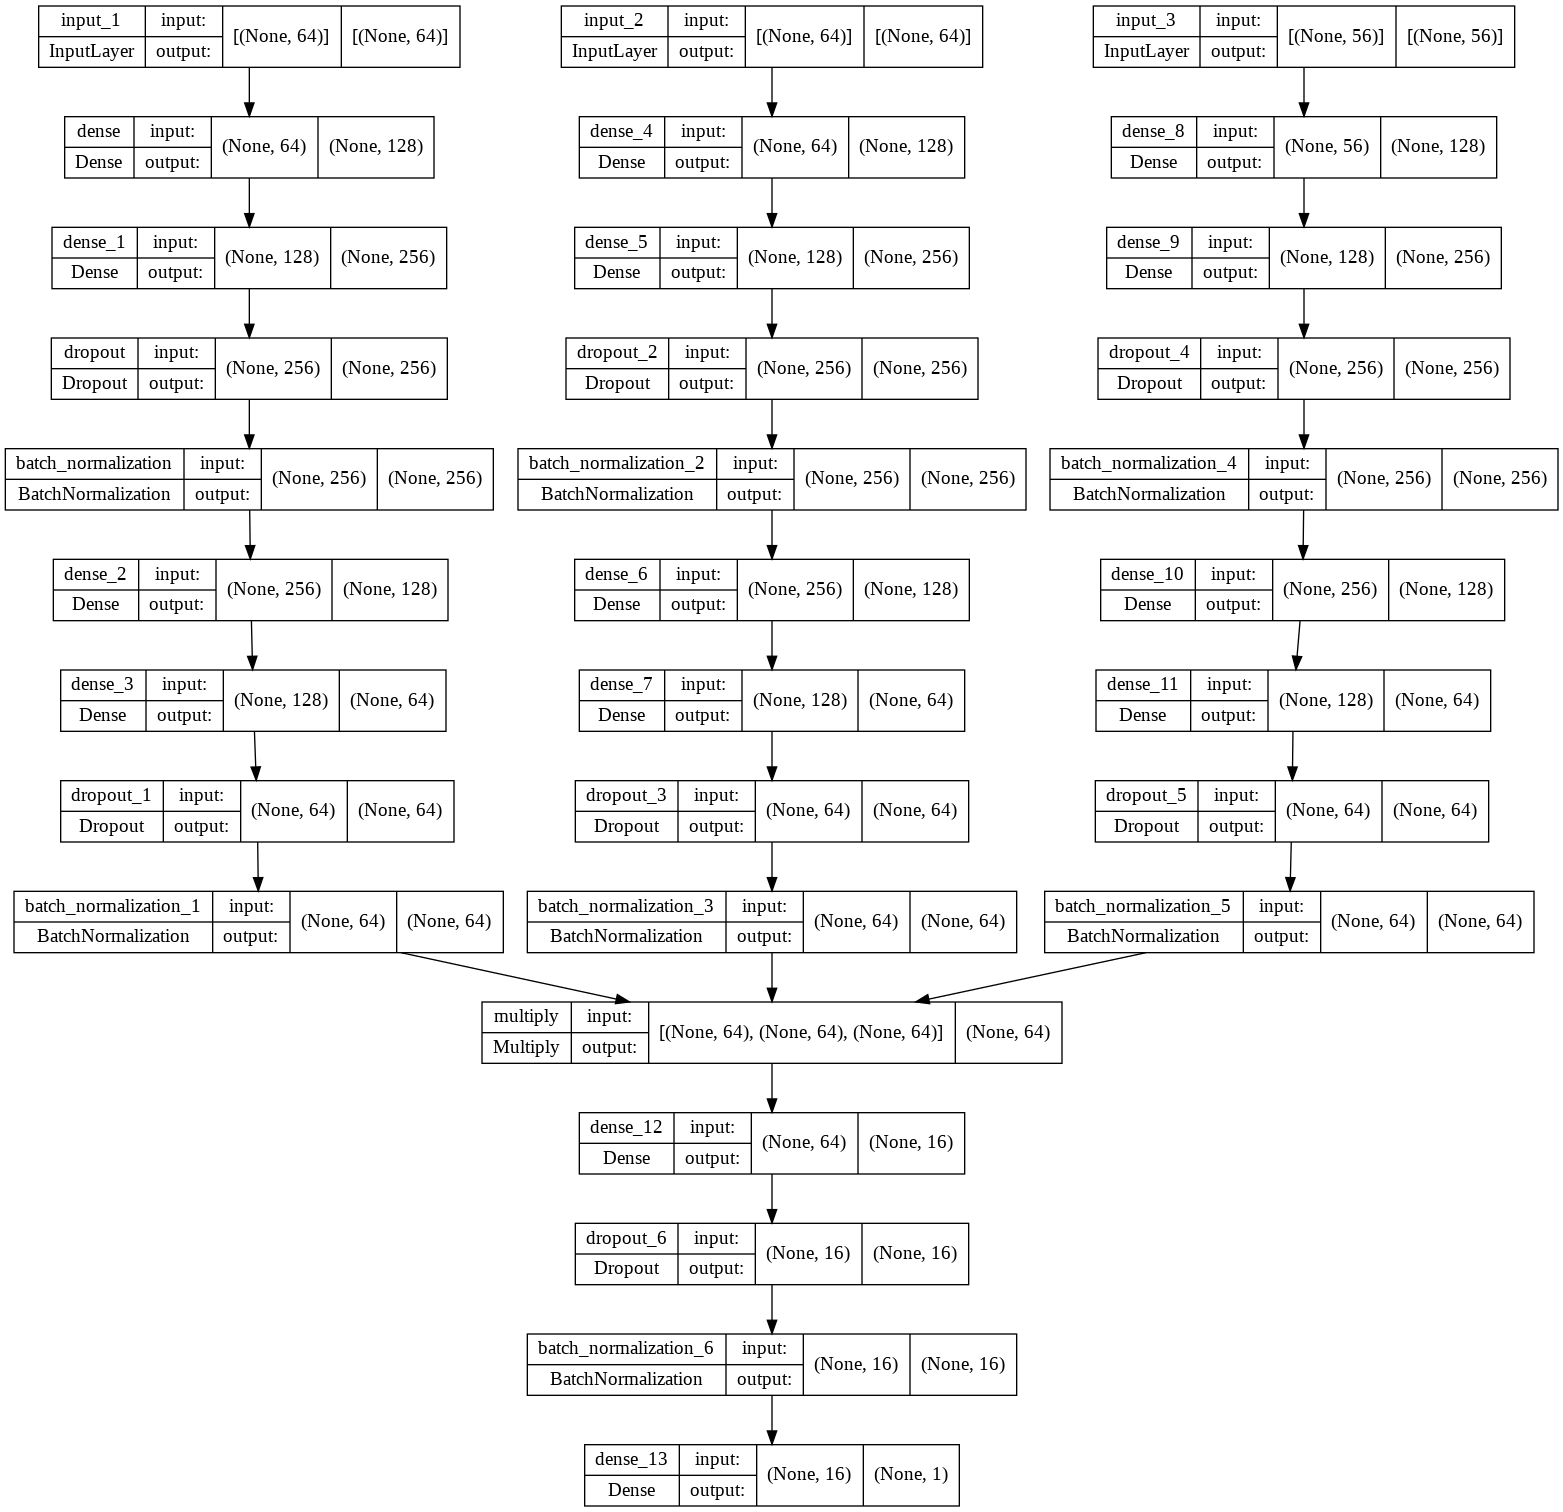

In [ ]:
earlystop = EarlyStopping(monitor = 'val_loss', patience=6, verbose = 1)
modelcheckpt = ModelCheckpoint(filepath=model_name+".h5")
tensorflow.keras.utils.plot_model(model7, to_file=model_name+'.png', show_shapes=True)

In [ ]:
history = model7.fit([train_src, train_dest, train_heuristic], train_y, epochs=50, verbose=1, 
                     batch_size=128, validation_data=([test_src, test_dest, test_heuristic], test_y), callbacks=[earlystop, modelcheckpt])

Epoch 1/50
4037/4037 [==============================] - 42s 10ms/step - loss: 0.5673 - accuracy: 0.7022 - val_loss: 0.6235 - val_accuracy: 0.6231
Epoch 2/50
4037/4037 [==============================] - 39s 10ms/step - loss: 0.3690 - accuracy: 0.8436 - val_loss: 0.4853 - val_accuracy: 0.7438
Epoch 3/50
4037/4037 [==============================] - 39s 10ms/step - loss: 0.2654 - accuracy: 0.8967 - val_loss: 0.3904 - val_accuracy: 0.8141
Epoch 4/50
4037/4037 [==============================] - 51s 13ms/step - loss: 0.2134 - accuracy: 0.9190 - val_loss: 0.3275 - val_accuracy: 0.8682
Epoch 5/50
4037/4037 [==============================] - 58s 14ms/step - loss: 0.1842 - accuracy: 0.9325 - val_loss: 0.3282 - val_accuracy: 0.8556
Epoch 6/50
4037/4037 [==============================] - 58s 14ms/step - loss: 0.1684 - accuracy: 0.9391 - val_loss: 0.2969 - val_accuracy: 0.8781
Epoch 7/50
4037/4037 [==============================] - 40s 10ms/step - loss: 0.1587 - accuracy: 0.9430 - val_loss: 0.3237 -

In [ ]:
model7 = tensorflow.keras.models.load_model(model_name+".h5")
test_pred = model7.predict([test_src, test_dest, test_heuristic])
test_pred = [1 if x >= 0.5 else 0 for x in test_pred]
heuristic_hadamard_f1 = f1_score(test_y, test_pred)
print(heuristic_hadamard_f1)

0.8922776702390506


## Experiment 6
#### Input: WYS embedding of each node and heuristics separately (dim = 64 + 64 + 56), Model: Triple input model with hadamard product product of semi-final layers followed by sigmoud activation.

In [ ]:
# Creating the model
model_name = 'model8'
tensorflow.keras.backend.clear_session()

input1 = Input(shape=(64,))
x1 = Dense(128, activation='relu', kernel_initializer='he_normal')(input1)
# x1 = Dropout(0.2)(x1)
# x1 = BatchNormalization()(x1)

x1 = Dense(256, activation='relu', kernel_initializer='he_normal')(x1)
x1 = Dropout(0.2)(x1)
x1 = BatchNormalization()(x1)

x1 = Dense(128, activation='relu', kernel_initializer='he_normal')(x1)
# x1 = Dropout(0.2)(x1)
# x1 = BatchNormalization()(x1)

x1 = Dense(64, activation='relu', kernel_initializer='he_normal')(x1)
x1 = Dropout(0.2)(x1)
x1 = BatchNormalization()(x1)

input2 = Input(shape=(64,))
x2 = Dense(128, activation='relu', kernel_initializer='he_normal')(input2)
# x2 = Dropout(0.2)(x2)
# x2 = BatchNormalization()(x2)

x2 = Dense(256, activation='relu', kernel_initializer='he_normal')(x2)
x2 = Dropout(0.2)(x2)
x2 = BatchNormalization()(x2)

x2 = Dense(128, activation='relu', kernel_initializer='he_normal')(x2)
# x2 = Dropout(0.2)(x2)
# x2 = BatchNormalization()(x2)

x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(x2)
x2 = Dropout(0.2)(x2)
x2 = BatchNormalization()(x2)

input3 = Input(shape=(56,))
x3 = Dense(128, activation='relu', kernel_initializer='he_normal')(input3)
# x1 = Dropout(0.2)(x1)
# x1 = BatchNormalization()(x1)

x3 = Dense(128, activation='relu', kernel_initializer='he_normal')(x3)
x3 = Dropout(0.2)(x3)
x3 = BatchNormalization()(x3)

x3 = Dense(32, activation='relu', kernel_initializer='he_normal')(x3)
x3 = Dropout(0.2)(x3)
x3 = BatchNormalization()(x3)

x4 = Multiply()([x1, x2])

x4 = Dense(32, activation='relu', kernel_initializer='he_normal')(x4)
x4 = Dropout(0.2)(x4)
x4 = BatchNormalization()(x4)

x = Multiply()([x4, x3])

x = Dense(16, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

output = Dense(1, activation='sigmoid', kernel_initializer='glorot_normal')(x)

model8 = Model(inputs=[input1, input2, input3], outputs=output)
model8.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.0001),metrics='accuracy')
print(model8.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          8320        ['input_1[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 128)          8320        ['input_2[0][0]']                
                                                                                              

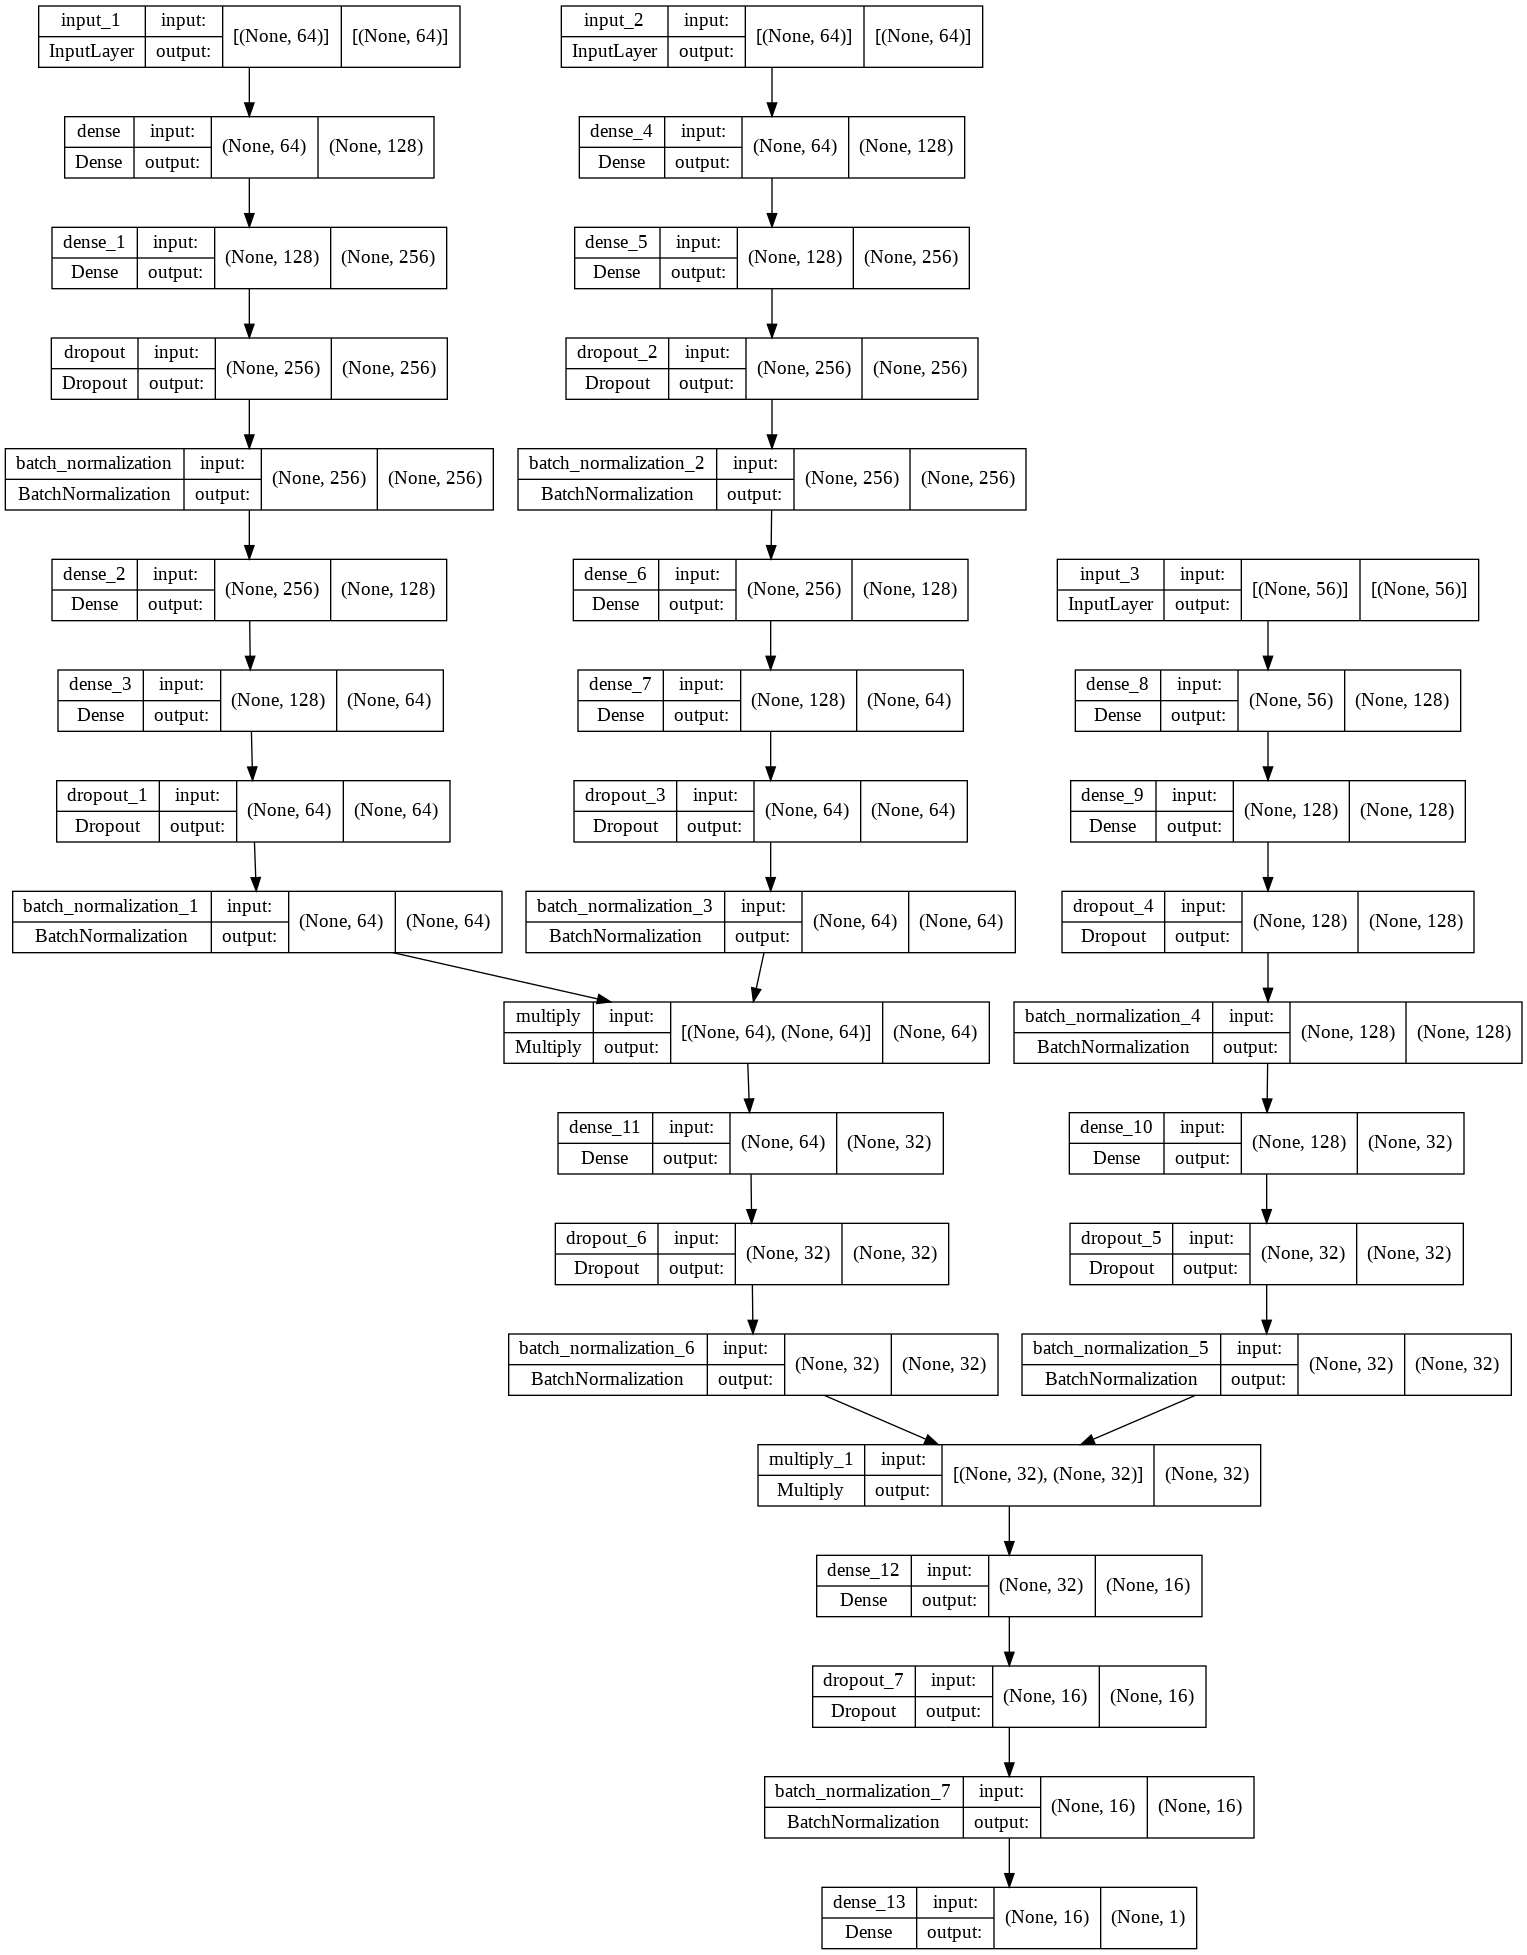

In [ ]:
earlystop = EarlyStopping(monitor = 'val_loss', patience=6, verbose = 1)
modelcheckpt = ModelCheckpoint(filepath=model_name+".h5")
tensorflow.keras.utils.plot_model(model8, to_file=model_name+'.png', show_shapes=True)

In [ ]:
history = model8.fit([train_src, train_dest, train_heuristic], train_y, epochs=50, verbose=1, batch_size=128, validation_data=([test_src, test_dest, test_heuristic], test_y), callbacks=[earlystop, modelcheckpt])

Epoch 1/50
4037/4037 [==============================] - 45s 11ms/step - loss: 0.5526 - accuracy: 0.7129 - val_loss: 0.5927 - val_accuracy: 0.6176
Epoch 2/50
4037/4037 [==============================] - 40s 10ms/step - loss: 0.3152 - accuracy: 0.8740 - val_loss: 0.4027 - val_accuracy: 0.8439
Epoch 3/50
4037/4037 [==============================] - 41s 10ms/step - loss: 0.2276 - accuracy: 0.9181 - val_loss: 0.4801 - val_accuracy: 0.7308
Epoch 4/50
4037/4037 [==============================] - 40s 10ms/step - loss: 0.1996 - accuracy: 0.9288 - val_loss: 0.4122 - val_accuracy: 0.8076
Epoch 5/50
4037/4037 [==============================] - 42s 11ms/step - loss: 0.1801 - accuracy: 0.9366 - val_loss: 0.3494 - val_accuracy: 0.8706
Epoch 6/50
4037/4037 [==============================] - 41s 10ms/step - loss: 0.1662 - accuracy: 0.9412 - val_loss: 0.3890 - val_accuracy: 0.8373
Epoch 7/50
4037/4037 [==============================] - 43s 11ms/step - loss: 0.1585 - accuracy: 0.9431 - val_loss: 0.3549 -

In [ ]:
model8 = tensorflow.keras.models.load_model(model_name+".h5")
test_pred = model8.predict([test_src, test_dest, test_heuristic])
test_pred = [1 if x >= 0.5 else 0 for x in test_pred]
heuristic_hadamard_f1 = f1_score(test_y, test_pred)
print(heuristic_hadamard_f1)

0.8598644865232012


## Experiment 7

* Input: WYS Embeddings of both nodes.
* Combinations are entirely using Concatenation. 
* Uses a slightly different architecture.
* Activation in hidden layers changed to ELU.

In [ ]:
# Creating the model
model_name = 'model9'
tensorflow.keras.backend.clear_session()

input1 = Input(shape=(64,))
x1 = Dense(128, activation='elu', kernel_initializer='he_normal')(input1)
x1 = Dropout(0.2)(x1)
x1 = BatchNormalization()(x1)

x1 = Dense(256, activation='elu', kernel_initializer='he_normal')(x1)

x1 = Dense(128, activation='elu', kernel_initializer='he_normal')(x1)
x1 = Dropout(0.2)(x1)
x1 = BatchNormalization()(x1)

input2 = Input(shape=(64,))
x2 = Dense(128, activation='elu', kernel_initializer='he_normal')(input2)
x2 = Dropout(0.2)(x2)
x2 = BatchNormalization()(x2)

x2 = Dense(256, activation='elu', kernel_initializer='he_normal')(x2)

x2 = Dense(128, activation='elu', kernel_initializer='he_normal')(x2)
x2 = Dropout(0.2)(x2)
x2 = BatchNormalization()(x2)

x = Concatenate()([x1, x2])

x = Dense(128, activation='elu', kernel_initializer='he_normal')(x)

x = Dense(64, activation='elu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

x = Dense(32, activation='elu', kernel_initializer='he_normal')(x)

x = Dense(16, activation='elu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

output = Dense(1, activation='sigmoid', kernel_initializer='glorot_normal')(x)

model9 = Model(inputs=[input1, input2], outputs=output)
model9.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.0001),metrics='accuracy')

In [ ]:
model9.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          8320        ['input_1[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 128)          8320        ['input_2[0][0]']                
                                                                                              

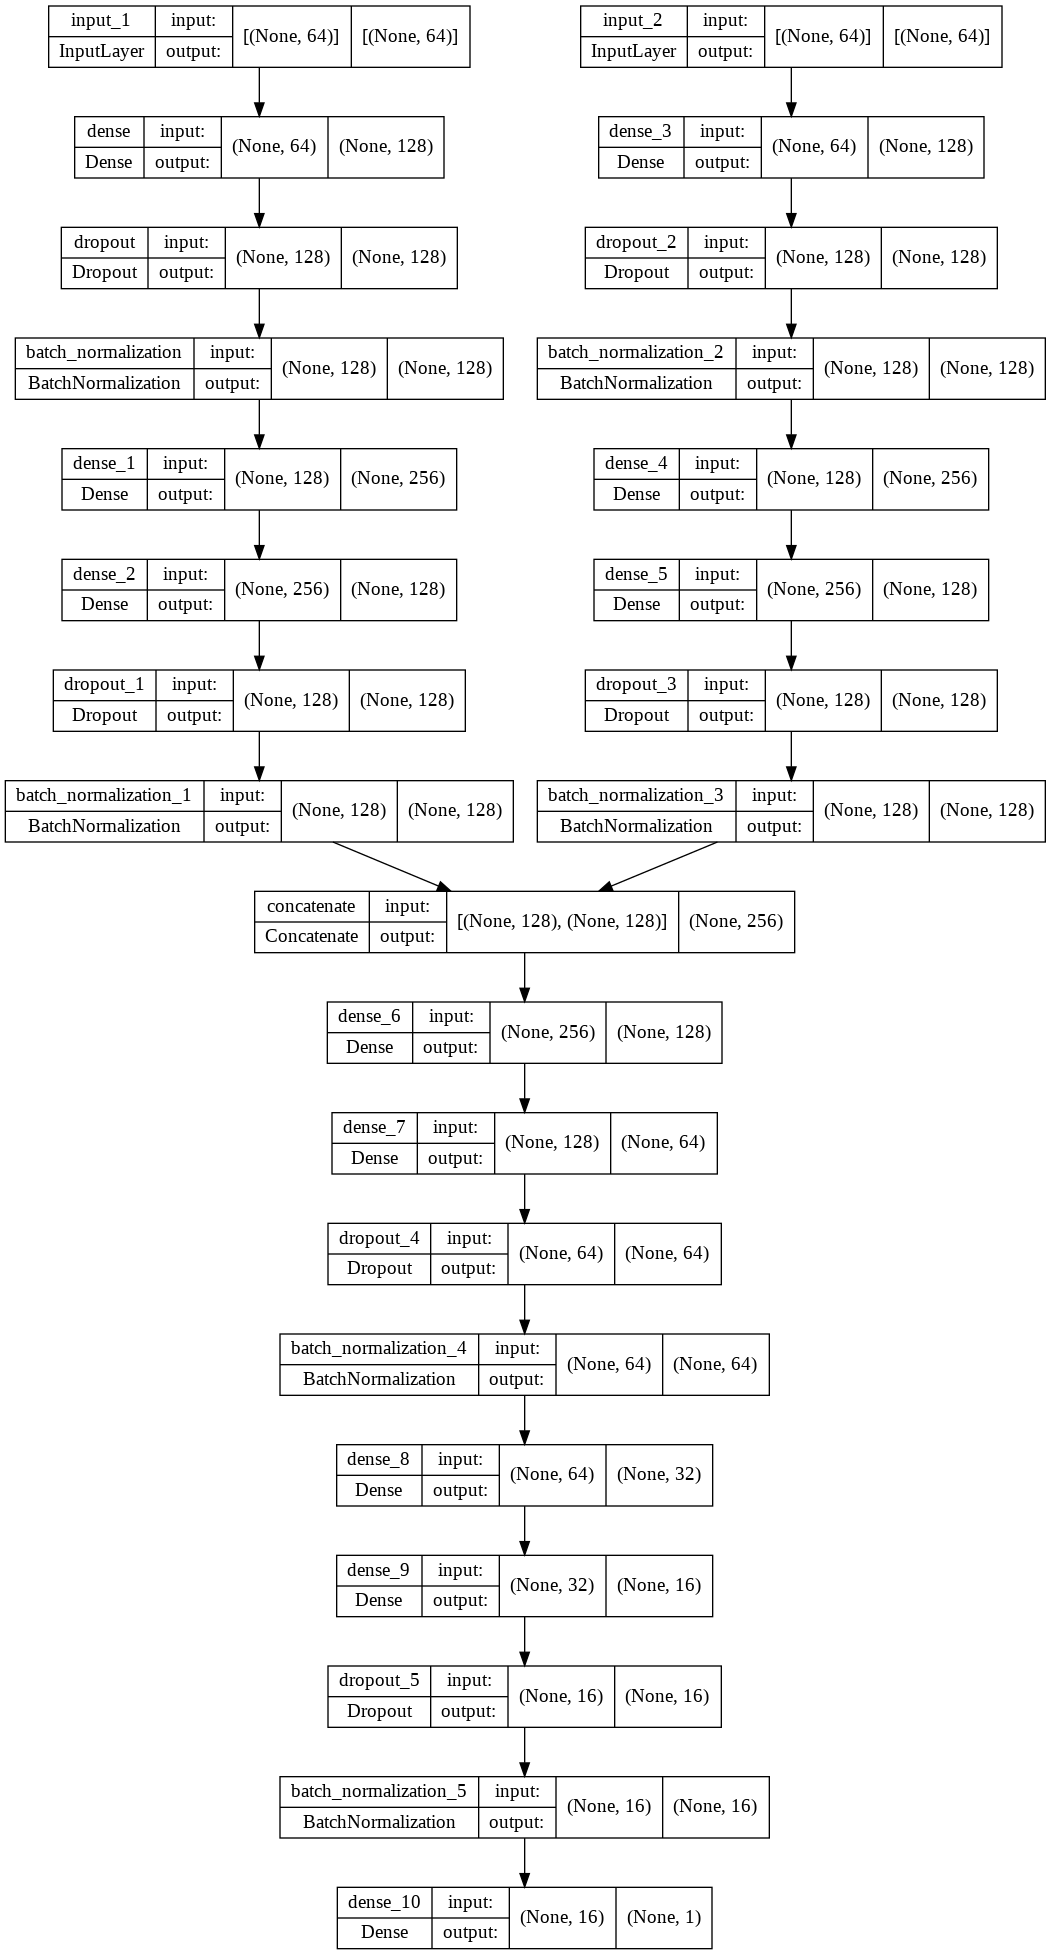

In [ ]:
earlystop = EarlyStopping(monitor = 'val_loss', patience=4, verbose = 1)
modelcheckpt = ModelCheckpoint(filepath=model_name+".h5")
tensorflow.keras.utils.plot_model(model9, to_file=model_name+'.png', show_shapes=True)

In [ ]:
history = model9.fit([train_src, train_dest], train_y, epochs=50, verbose=1, batch_size=128, validation_data=([test_src, test_dest], test_y), callbacks=[earlystop, modelcheckpt])

Epoch 1/50
4037/4037 [==============================] - 38s 8ms/step - loss: 0.4427 - accuracy: 0.7981 - val_loss: 0.3529 - val_accuracy: 0.8426
Epoch 2/50
4037/4037 [==============================] - 36s 9ms/step - loss: 0.3306 - accuracy: 0.8615 - val_loss: 0.3218 - val_accuracy: 0.8619
Epoch 3/50
4037/4037 [==============================] - 31s 8ms/step - loss: 0.3022 - accuracy: 0.8747 - val_loss: 0.3157 - val_accuracy: 0.8663
Epoch 4/50
4037/4037 [==============================] - 32s 8ms/step - loss: 0.2884 - accuracy: 0.8810 - val_loss: 0.3108 - val_accuracy: 0.8688
Epoch 5/50
4037/4037 [==============================] - 32s 8ms/step - loss: 0.2818 - accuracy: 0.8838 - val_loss: 0.3145 - val_accuracy: 0.8690
Epoch 6/50
4037/4037 [==============================] - 31s 8ms/step - loss: 0.2761 - accuracy: 0.8859 - val_loss: 0.3083 - val_accuracy: 0.8724
Epoch 7/50
4037/4037 [==============================] - 31s 8ms/step - loss: 0.2709 - accuracy: 0.8883 - val_loss: 0.3125 - val_ac

In [ ]:
test_pred = model9.predict([test_src, test_dest])
test_pred = [1 if x >= 0.5 else 0 for x in test_pred]
heuristic_hadamard_f1 = f1_score(test_y, test_pred)
print(heuristic_hadamard_f1)

0.8771718295925308


## Experiment 8

* Input: Only heurisitcs.
* Uses different activation (ELU).
* Precursor to experiment 11 that combines WYS with the heuristics.

In [ ]:
# Creating the model
model_name = 'model10'
tensorflow.keras.backend.clear_session()

input = Input(shape=(56,))

x = input

x = Dense(128, activation='elu', kernel_initializer='he_normal')(x)

x = Dense(64, activation='elu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

x = Dense(32, activation='elu', kernel_initializer='he_normal')(x)

x = Dense(16, activation='elu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

output = Dense(1, activation='sigmoid', kernel_initializer='glorot_normal')(x)

model10 = Model(inputs=[input], outputs=output)
model10.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.0001),metrics='accuracy')

In [ ]:
model10.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 56)]              0         
                                                                 
 dense (Dense)               (None, 128)               7296      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                             

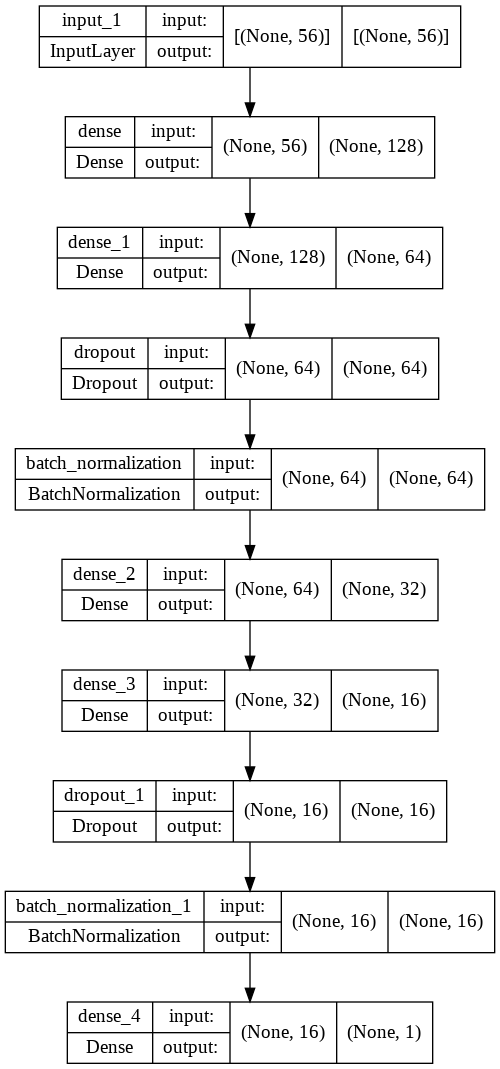

In [ ]:
earlystop = EarlyStopping(monitor = 'val_loss', patience=4, verbose = 1)
modelcheckpt = ModelCheckpoint(filepath=model_name+".h5")
tensorflow.keras.utils.plot_model(model10, to_file=model_name+'.png', show_shapes=True)

In [ ]:
history = model10.fit([train_heuristic], train_y, epochs=50, verbose=1, batch_size=128, validation_data=([test_heuristic], test_y), callbacks=[earlystop, modelcheckpt])

Epoch 1/50
4037/4037 [==============================] - 18s 4ms/step - loss: 0.3237 - accuracy: 0.8680 - val_loss: 0.3256 - val_accuracy: 0.8697
Epoch 2/50
4037/4037 [==============================] - 17s 4ms/step - loss: 0.2101 - accuracy: 0.9265 - val_loss: 0.3068 - val_accuracy: 0.8748
Epoch 3/50
4037/4037 [==============================] - 17s 4ms/step - loss: 0.1898 - accuracy: 0.9348 - val_loss: 0.2975 - val_accuracy: 0.8801
Epoch 4/50
4037/4037 [==============================] - 17s 4ms/step - loss: 0.1805 - accuracy: 0.9381 - val_loss: 0.2875 - val_accuracy: 0.8788
Epoch 5/50
4037/4037 [==============================] - 17s 4ms/step - loss: 0.1734 - accuracy: 0.9400 - val_loss: 0.2935 - val_accuracy: 0.8797
Epoch 6/50
4037/4037 [==============================] - 17s 4ms/step - loss: 0.1678 - accuracy: 0.9416 - val_loss: 0.2979 - val_accuracy: 0.8766
Epoch 7/50
4037/4037 [==============================] - 17s 4ms/step - loss: 0.1662 - accuracy: 0.9415 - val_loss: 0.2938 - val_ac

In [ ]:
test_pred = model10.predict([test_heuristic])
test_pred = [1 if x >= 0.5 else 0 for x in test_pred]
heuristic_hadamard_f1 = f1_score(test_y, test_pred)
print(heuristic_hadamard_f1)

0.8881340715247644


## Experiment 9

Input: WYS Embeddings of both nodes + Heuristics (64 + 64 + 56). Uses a slightly different architecture. Combinations are made entirely by concatenation. Activation in hidden layers is ELU.

In [23]:
# Creating the model
model_name = 'model11'
tensorflow.keras.backend.clear_session()

input1 = Input(shape=(64,))
x1 = Dense(128, activation='elu', kernel_initializer='he_normal')(input1)
x1 = Dropout(0.2)(x1)
x1 = BatchNormalization()(x1)

x1 = Dense(256, activation='elu', kernel_initializer='he_normal')(x1)

x1 = Dense(128, activation='elu', kernel_initializer='he_normal')(x1)
x1 = Dropout(0.2)(x1)
x1 = BatchNormalization()(x1)

input2 = Input(shape=(64,))
x2 = Dense(128, activation='elu', kernel_initializer='he_normal')(input2)
x2 = Dropout(0.2)(x2)
x2 = BatchNormalization()(x2)

x2 = Dense(256, activation='elu', kernel_initializer='he_normal')(x2)

x2 = Dense(128, activation='elu', kernel_initializer='he_normal')(x2)
x2 = Dropout(0.2)(x2)
x2 = BatchNormalization()(x2)

input3 = Input(shape=(56,))

x = Concatenate()([x1, x2, input3])

x = Dense(128, activation='elu', kernel_initializer='he_normal')(x)

x = Dense(64, activation='elu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

x = Dense(32, activation='elu', kernel_initializer='he_normal')(x)

x = Dense(16, activation='elu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

output = Dense(1, activation='sigmoid', kernel_initializer='glorot_normal')(x)

model11 = Model(inputs=[input1, input2, input3], outputs=output)
model11.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.0001),metrics='accuracy')

In [29]:
model11.save('modelname')

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
import visualkeras
visualkeras.layered_view(model11).show()

In [ ]:
model11.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          8320        ['input_1[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 128)          8320        ['input_2[0][0]']                
                                                                                              

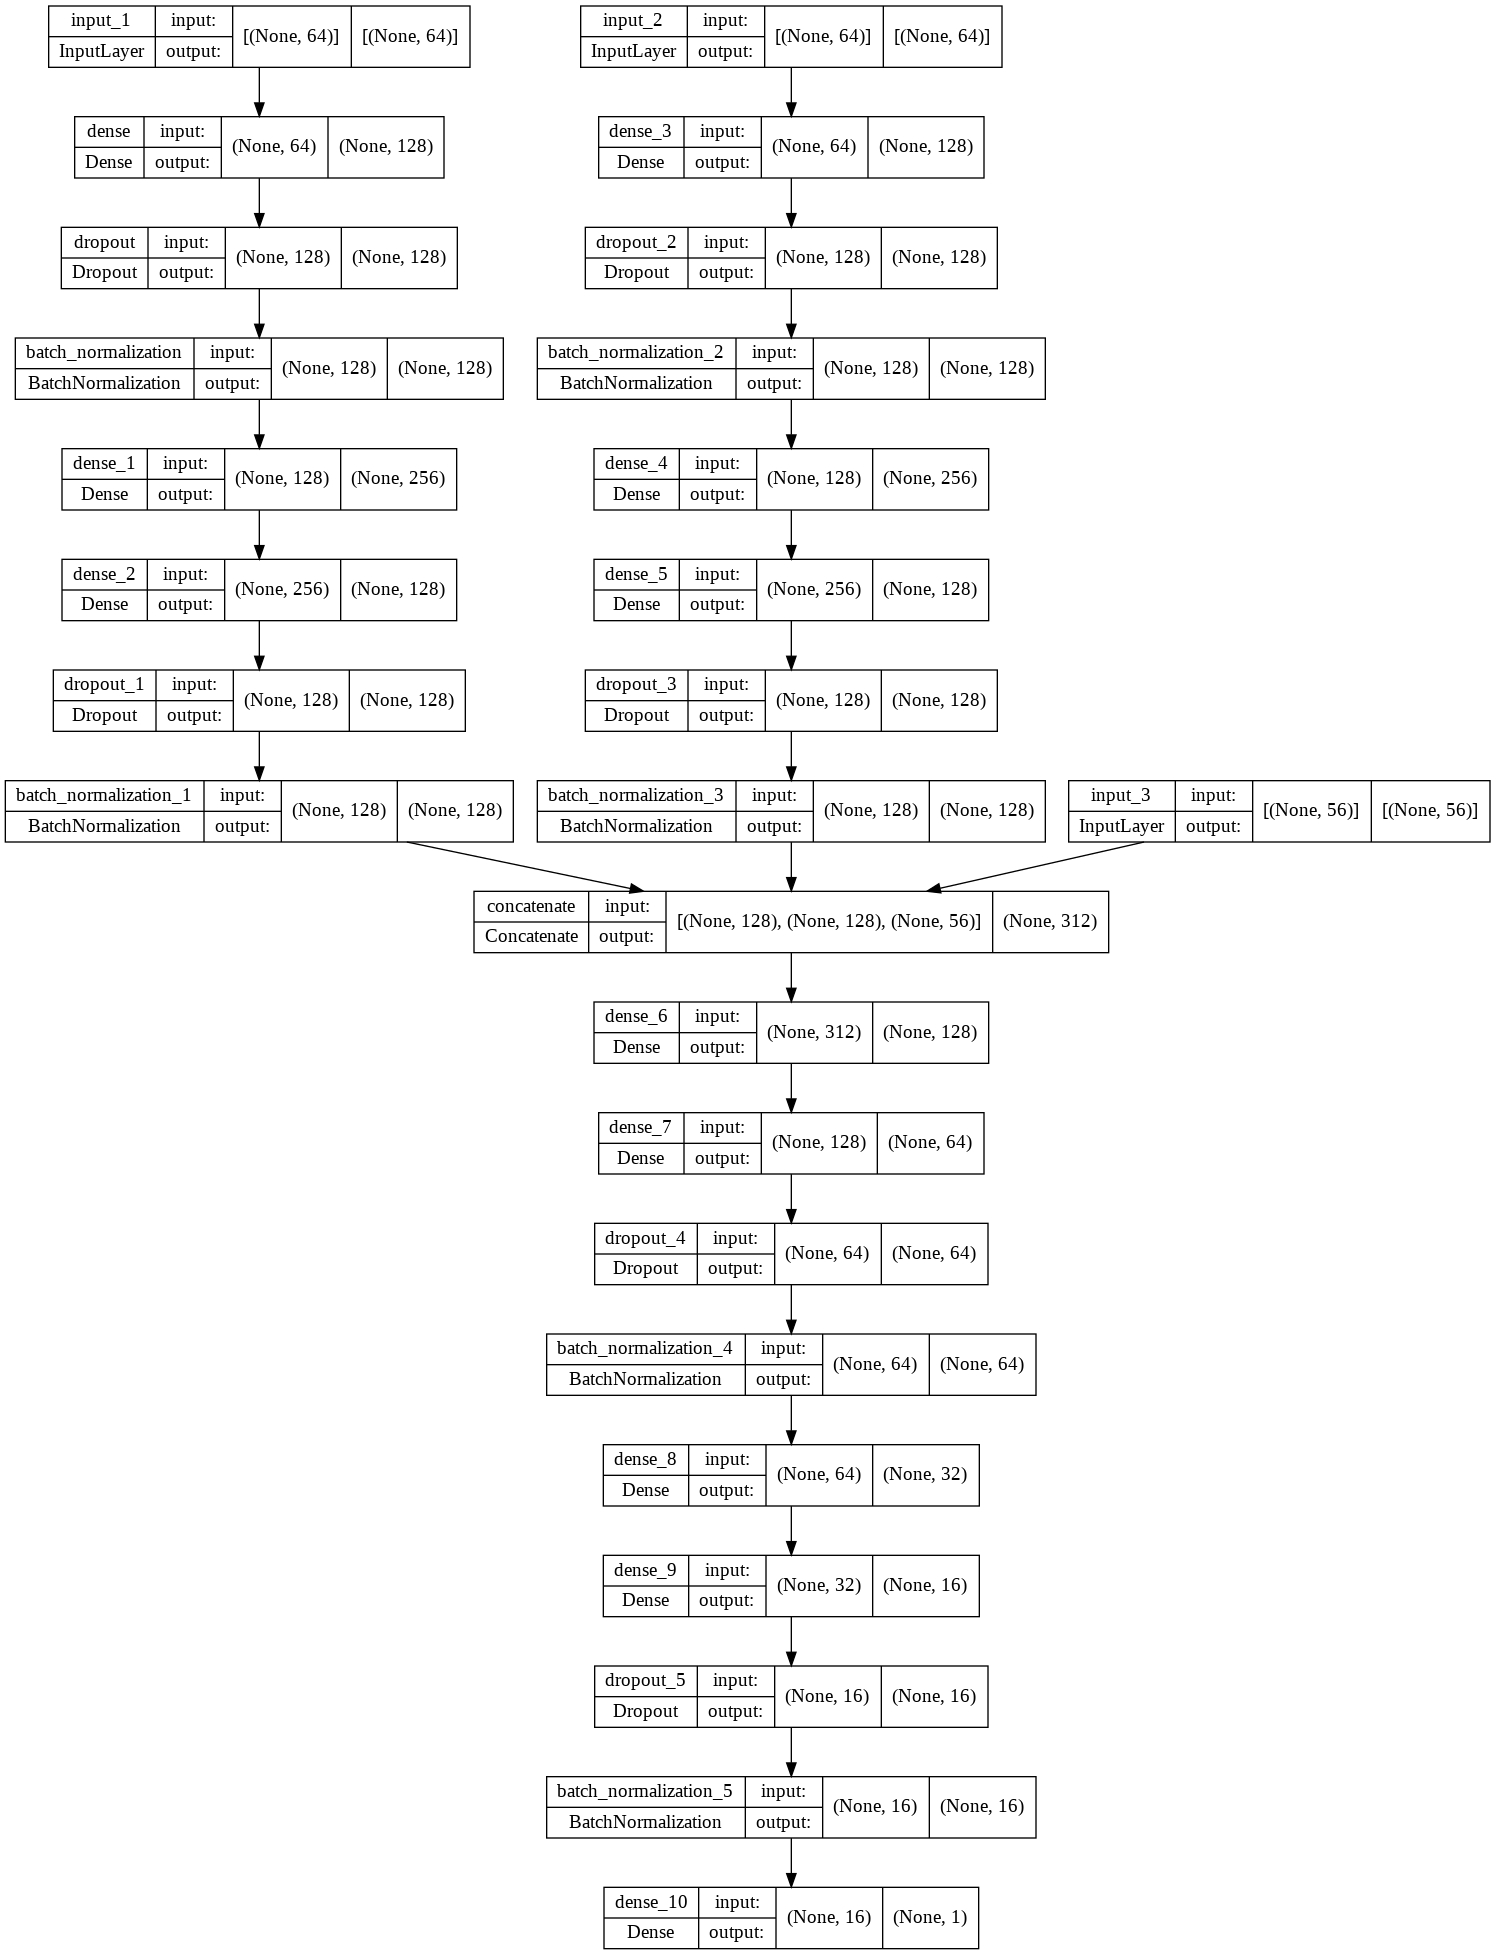

In [ ]:
earlystop = EarlyStopping(monitor = 'val_loss', patience=4, verbose = 1)
modelcheckpt = ModelCheckpoint(filepath=model_name+".h5")
tensorflow.keras.utils.plot_model(model11, to_file=model_name+'.png', show_shapes=True)

In [ ]:
history = model11.fit([train_src, train_dest, train_heuristic], train_y, epochs=50, verbose=1, batch_size=128, validation_data=([test_src, test_dest, test_heuristic], test_y), callbacks=[earlystop, modelcheckpt])

Epoch 1/50
4037/4037 [==============================] - 40s 9ms/step - loss: 0.3107 - accuracy: 0.8776 - val_loss: 0.2828 - val_accuracy: 0.8854
Epoch 2/50
4037/4037 [==============================] - 31s 8ms/step - loss: 0.1768 - accuracy: 0.9404 - val_loss: 0.2969 - val_accuracy: 0.8862
Epoch 3/50
4037/4037 [==============================] - 32s 8ms/step - loss: 0.1547 - accuracy: 0.9479 - val_loss: 0.3047 - val_accuracy: 0.8805
Epoch 4/50
4037/4037 [==============================] - 32s 8ms/step - loss: 0.1434 - accuracy: 0.9516 - val_loss: 0.2960 - val_accuracy: 0.8865
Epoch 5/50
4037/4037 [==============================] - 31s 8ms/step - loss: 0.1370 - accuracy: 0.9539 - val_loss: 0.3085 - val_accuracy: 0.8874
Epoch 5: early stopping


In [ ]:
model11 = tensorflow.keras.models.load_model(model_name+".h5")
test_pred = model11.predict([test_src, test_dest, test_heuristic])
test_pred = [1 if x >= 0.5 else 0 for x in test_pred]
heuristic_hadamard_f1 = f1_score(test_y, test_pred)
print(heuristic_hadamard_f1)

0.8903469716142537


## Experiment 10

Exactly same as [Experiment 9](https://colab.research.google.com/drive/1CXbpsj4xJYElmJi2PRdJsT2GQOleRBKD#scrollTo=l_aNhf4XgqCg&line=1&uniqifier=1), but uses Hadamard product for combining embeddings.

In [ ]:
# Creating the model
model_name = 'model12'
tensorflow.keras.backend.clear_session()

input1 = Input(shape=(64,))
x1 = Dense(128, activation='elu', kernel_initializer='he_normal')(input1)
x1 = Dropout(0.2)(x1)
x1 = BatchNormalization()(x1)

x1 = Dense(256, activation='elu', kernel_initializer='he_normal')(x1)

x1 = Dense(128, activation='elu', kernel_initializer='he_normal')(x1)
x1 = Dropout(0.2)(x1)
x1 = BatchNormalization()(x1)

input2 = Input(shape=(64,))
x2 = Dense(128, activation='elu', kernel_initializer='he_normal')(input2)
x2 = Dropout(0.2)(x2)
x2 = BatchNormalization()(x2)

x2 = Dense(256, activation='elu', kernel_initializer='he_normal')(x2)

x2 = Dense(128, activation='elu', kernel_initializer='he_normal')(x2)
x2 = Dropout(0.2)(x2)
x2 = BatchNormalization()(x2)

x = Multiply()([x1, x2])

x = Dense(64, activation='elu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

x = Dense(32, activation='elu', kernel_initializer='he_normal')(x)

x = Dense(16, activation='elu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

output = Dense(1, activation='sigmoid', kernel_initializer='glorot_normal')(x)

model12 = Model(inputs=[input1, input2], outputs=output)
model12.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.0001),metrics='accuracy')

In [ ]:
model12.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          8320        ['input_1[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 128)          8320        ['input_2[0][0]']                
                                                                                              

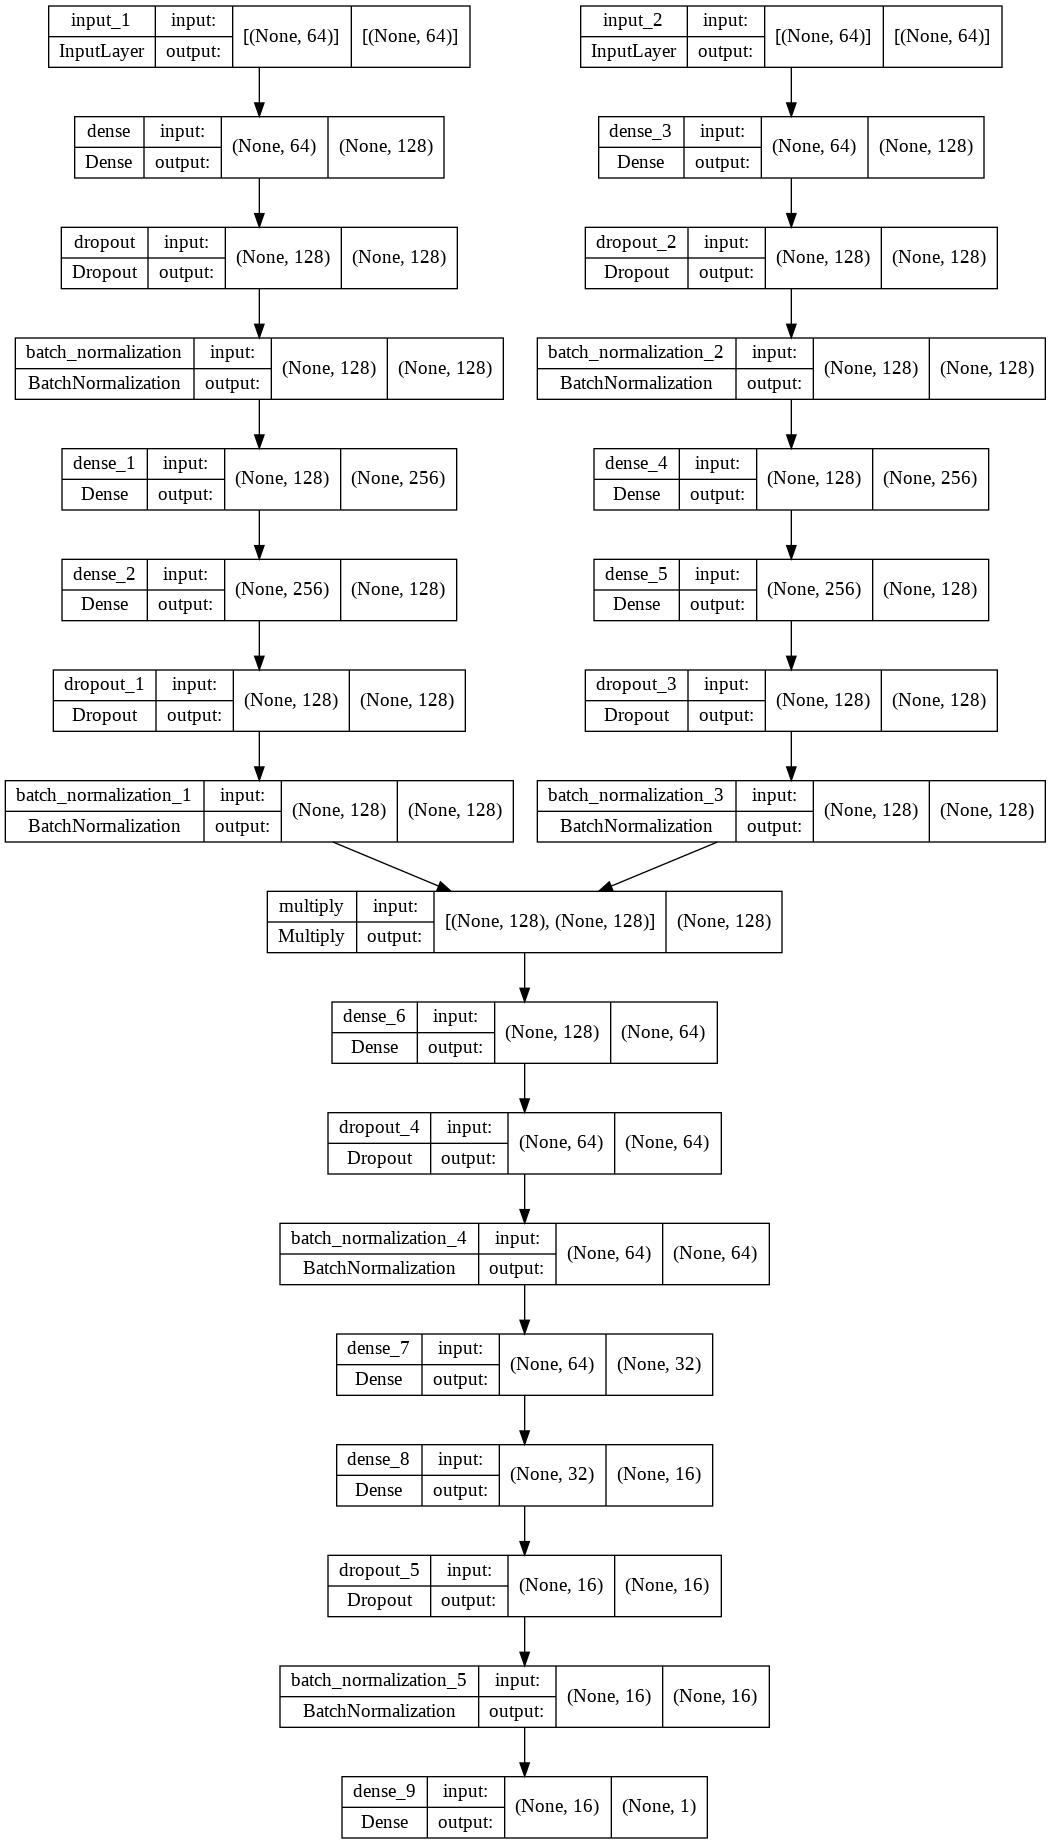

In [ ]:
earlystop = EarlyStopping(monitor = 'val_loss', patience=4, verbose = 1)
modelcheckpt = ModelCheckpoint(filepath=model_name+".h5")
tensorflow.keras.utils.plot_model(model12, to_file=model_name+'.png', show_shapes=True)

In [ ]:
history = model12.fit([train_src, train_dest], train_y, epochs=50, verbose=1, batch_size=128, validation_data=([test_src, test_dest], test_y), callbacks=[earlystop, modelcheckpt])

Epoch 1/50
4037/4037 [==============================] - 37s 8ms/step - loss: 0.6115 - accuracy: 0.6687 - val_loss: 0.3940 - val_accuracy: 0.8240
Epoch 2/50
4037/4037 [==============================] - 33s 8ms/step - loss: 0.3771 - accuracy: 0.8415 - val_loss: 0.3409 - val_accuracy: 0.8513
Epoch 3/50
4037/4037 [==============================] - 32s 8ms/step - loss: 0.3297 - accuracy: 0.8624 - val_loss: 0.3311 - val_accuracy: 0.8591
Epoch 4/50
4037/4037 [==============================] - 32s 8ms/step - loss: 0.3092 - accuracy: 0.8717 - val_loss: 0.3199 - val_accuracy: 0.8653
Epoch 5/50
4037/4037 [==============================] - 33s 8ms/step - loss: 0.2964 - accuracy: 0.8778 - val_loss: 0.3175 - val_accuracy: 0.8671
Epoch 6/50
4037/4037 [==============================] - 31s 8ms/step - loss: 0.2894 - accuracy: 0.8807 - val_loss: 0.3162 - val_accuracy: 0.8677
Epoch 7/50
4037/4037 [==============================] - 45s 11ms/step - loss: 0.2828 - accuracy: 0.8840 - val_loss: 0.3173 - val_a

In [ ]:
test_pred = model12.predict([test_src, test_dest])
test_pred = [1 if x >= 0.5 else 0 for x in test_pred]
heuristic_hadamard_f1 = f1_score(test_y, test_pred)
print(heuristic_hadamard_f1)

0.8782999844889097


## Experiment 11

Exactly same as Experiment 11 but uses Hadamard product to combine the embeddings and heuristics.

In [ ]:
# Creating the model
model_name = 'model13'
tensorflow.keras.backend.clear_session()

input1 = Input(shape=(64,))
x1 = Dense(128, activation='elu', kernel_initializer='he_normal')(input1)
x1 = Dropout(0.2)(x1)
x1 = BatchNormalization()(x1)

x1 = Dense(256, activation='elu', kernel_initializer='he_normal')(x1)

x1 = Dense(128, activation='elu', kernel_initializer='he_normal')(x1)
x1 = Dropout(0.2)(x1)
x1 = BatchNormalization()(x1)

input2 = Input(shape=(64,))
x2 = Dense(128, activation='elu', kernel_initializer='he_normal')(input2)
x2 = Dropout(0.2)(x2)
x2 = BatchNormalization()(x2)

x2 = Dense(256, activation='elu', kernel_initializer='he_normal')(x2)

x2 = Dense(128, activation='elu', kernel_initializer='he_normal')(x2)
x2 = Dropout(0.2)(x2)
x2 = BatchNormalization()(x2)

input3 = Input(shape=(56,))

x3 = Dense(128, activation='elu', kernel_initializer='he_normal')(input3)

x = Multiply()([x1, x2, x3])

x = Dense(64, activation='elu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

x = Dense(32, activation='elu', kernel_initializer='he_normal')(x)

x = Dense(16, activation='elu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

output = Dense(1, activation='sigmoid', kernel_initializer='glorot_normal')(x)

model13 = Model(inputs=[input1, input2, input3], outputs=output)
model13.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.0001),metrics='accuracy')

In [ ]:
model13.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          8320        ['input_1[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 128)          8320        ['input_2[0][0]']                
                                                                                              

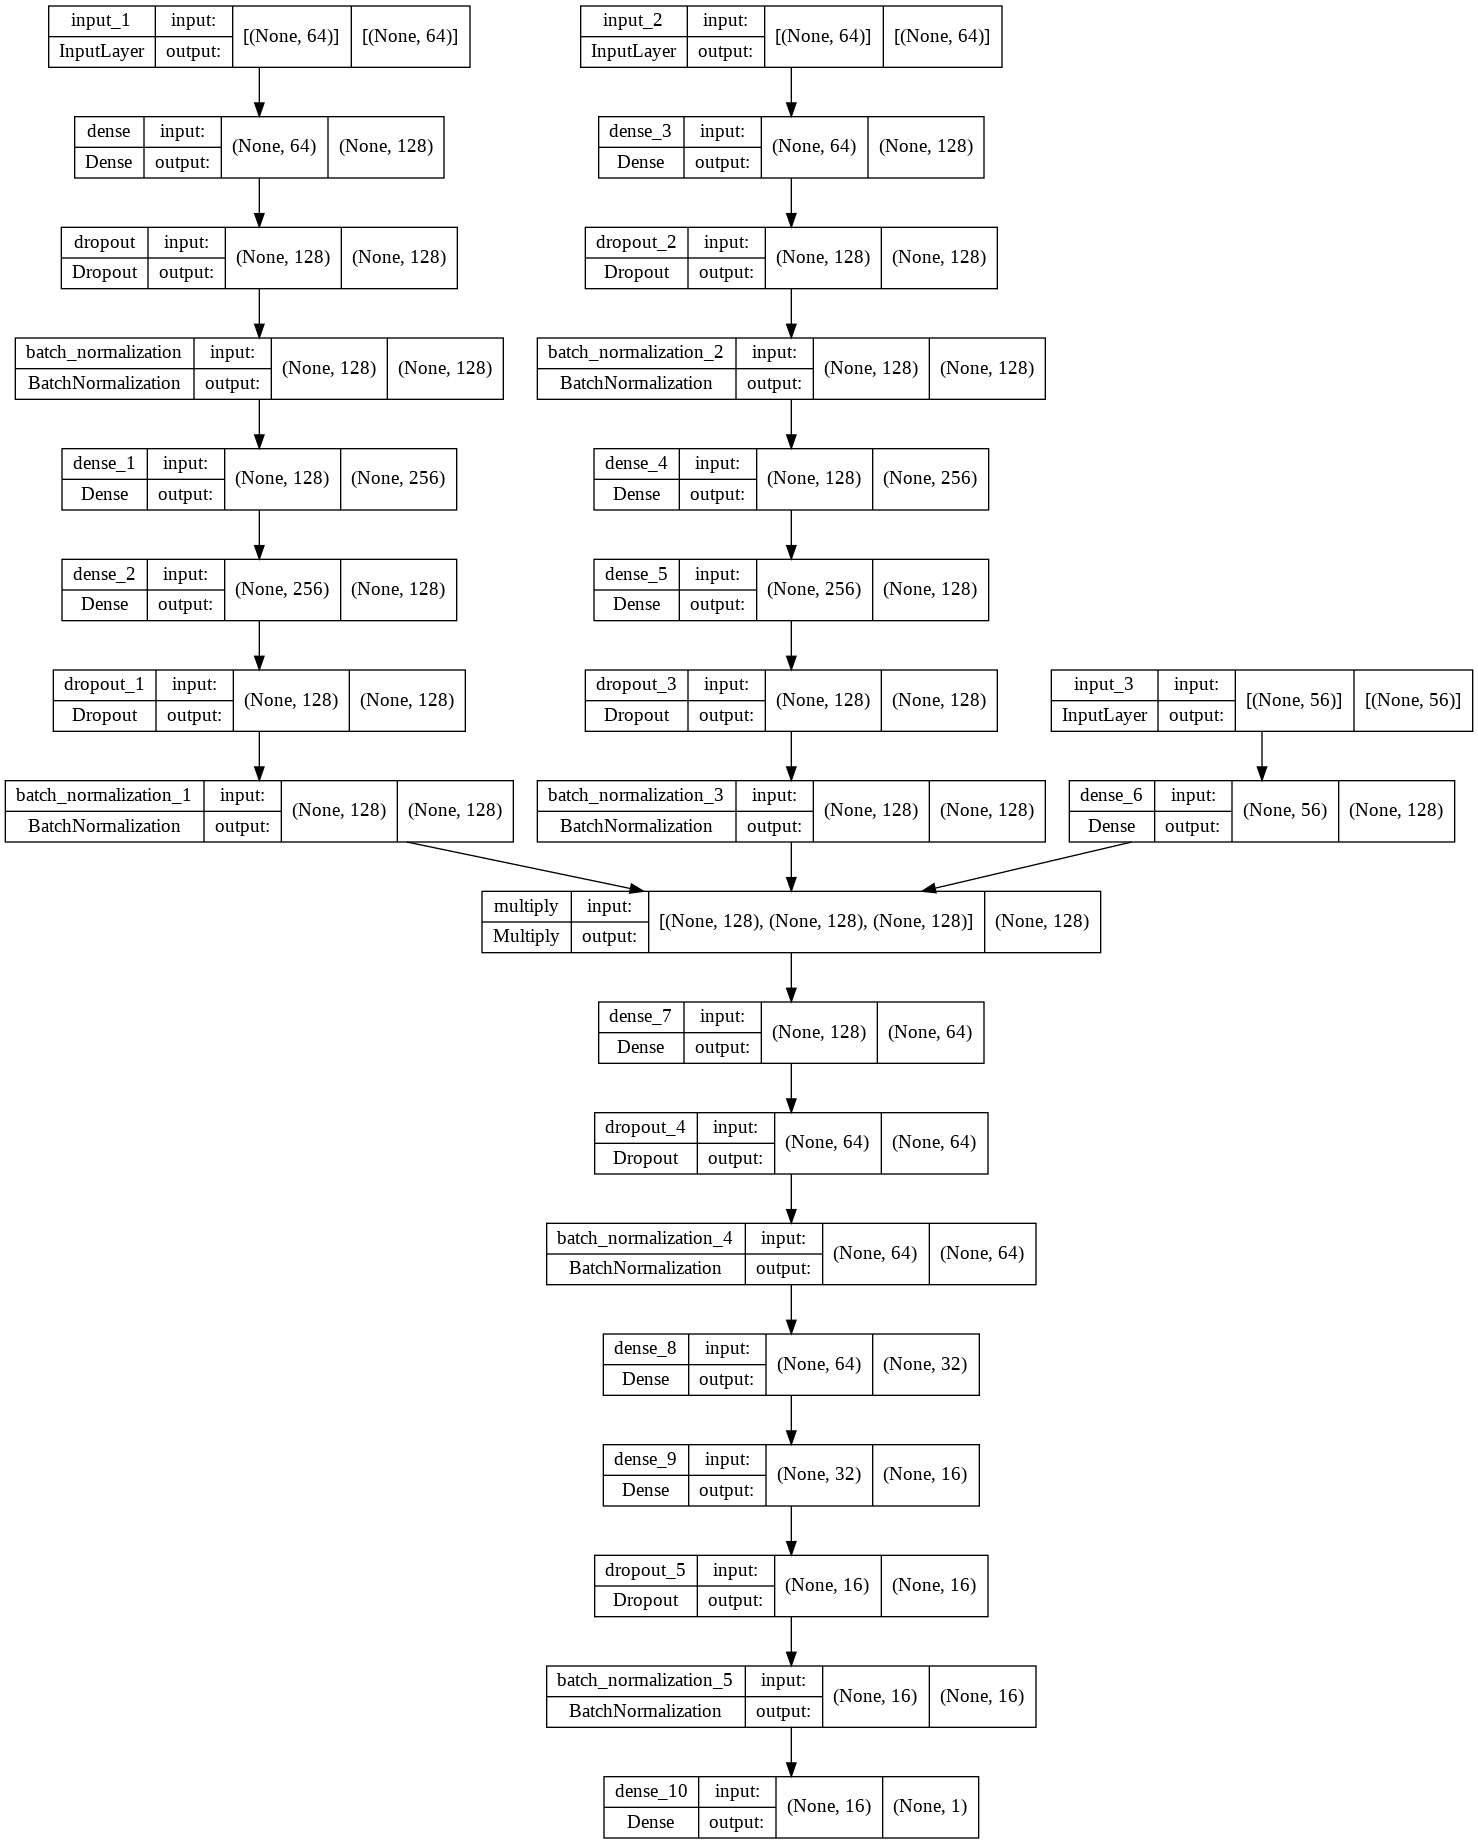

In [ ]:
earlystop = EarlyStopping(monitor = 'val_loss', patience=6, verbose = 1)
modelcheckpt = ModelCheckpoint(filepath=model_name+".h5")
tensorflow.keras.utils.plot_model(model13, to_file=model_name+'.png', show_shapes=True)

In [ ]:
history = model13.fit([train_src, train_dest, train_heuristic], train_y, epochs=50, verbose=1, batch_size=128, validation_data=([test_src, test_dest, test_heuristic], test_y), callbacks=[earlystop, modelcheckpt])

Epoch 1/50
4037/4037 [==============================] - 42s 9ms/step - loss: 0.4930 - accuracy: 0.7636 - val_loss: 1.5533 - val_accuracy: 0.5347
Epoch 2/50
4037/4037 [==============================] - 35s 9ms/step - loss: 0.3868 - accuracy: 0.8398 - val_loss: 1.6712 - val_accuracy: 0.5347
Epoch 3/50
4037/4037 [==============================] - 37s 9ms/step - loss: 0.3363 - accuracy: 0.8649 - val_loss: 1.6642 - val_accuracy: 0.5347
Epoch 4/50
4037/4037 [==============================] - 36s 9ms/step - loss: 0.2931 - accuracy: 0.8847 - val_loss: 1.5783 - val_accuracy: 0.5347
Epoch 5/50
4037/4037 [==============================] - 35s 9ms/step - loss: 0.2582 - accuracy: 0.8998 - val_loss: 1.5120 - val_accuracy: 0.5347
Epoch 6/50
4037/4037 [==============================] - 37s 9ms/step - loss: 0.2251 - accuracy: 0.9152 - val_loss: 1.5557 - val_accuracy: 0.5347
Epoch 7/50
4037/4037 [==============================] - 36s 9ms/step - loss: 0.1941 - accuracy: 0.9311 - val_loss: 1.4782 - val_ac

In [ ]:
# model13 = tensorflow.keras.models.load_model(model_name+".h5")
test_pred = model13.predict([test_src, test_dest, test_heuristic])
test_pred = [1 if x >= 0.5 else 0 for x in test_pred]
heuristic_hadamard_f1 = f1_score(test_y, test_pred)
print(heuristic_hadamard_f1)

0.8851970634281284
